# Prediction of News Shares

*This notebook outlines the analysis and process to create predictive regression model for aricle shares, given a number of features based on article content.*

*Data pulled from: https://www.kaggle.com/yamqwe/predicting-number-of-shares-of-news-articles*

## Framing the Problem

### Objective
Build a predictive model for the number of shares generatd by a news article based on the content of the article. Given an effective predictive model, attempt to identify which features have the highest impact on share predictions to gain insight on reader behaviour.

### Application
These insight can be used by news publications in enhancing their content to reach a larger audience by increasing the average number of shares, significantly improving the ability of journalists to spread information on critical issues to the public.
Insights gained from this analysis could also help to educate readers on their own behaviour, allowing them to evaluate their decision to share certain articles to take a more considered approach when spreading news.

### Model + Metrics
The model will use a supervised regression algorithm to predict the number of shares. Model performance will be mesured using a cross validation approach to obtain the mean RMSE. A lower out-of-sample RMSE indicates that the model has captured more powerful signals into the drivers behind shares. Given a median of 1,400 shares per article in the acquired data set, we aim for a performance of RMSE = 140 (10%)

## Data Acquisiion

### Data Source
Data obtained from https://www.kaggle.com/yamqwe/predicting-number-of-shares-of-news-articles

-- Creators: Kelwin Fernandes (kafc@inesctec.pt, kelwinfc@gmail.com),
             Pedro Vinagre (pedro.vinagre.sousa@gmail.com) and
             Pedro Sernadela
             
-- Donor: Kelwin Fernandes (kafc@inesctec.pt, kelwinfc@gmail.com)

-- Date: May, 2015

### Past Usage
K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015

- Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

   -- Results:
   
      -- Binary classification as popular vs unpopular using a decision threshold of 1400 social interactions.
      
      -- Experiments with different models: Random Forest (best model), Adaboost, SVM, KNN and Naïve Bayes.
      
      -- Recorded 67% of accuracy and 0.73 of AUC.
      
- Predicted attribute: online news popularity (boolean)

### Relevant Information
-- The articles were published by Mashable (www.mashable.com) and their content as the rights to reproduce it belongs to them. Hence, this dataset does not share the original content but some statistics associated with it. The original content be publicly accessed and retrieved using the provided urls.

-- Acquisition date: January 8, 2015

-- The estimated relative performance values were estimated by the authors using a Random Forest classifier and a rolling windows as assessment method. See their article for more details on how the relative performance values were set.

Number of Instances: 39797

Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field)

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Load the Data

In [2]:
import pandas as pd

data = pd.read_csv("OnlineNewsPopularity.csv")

## Data Exploration

In [3]:
import pandas_profiling

data.profile_report(minimal=True).to_widgets()

Summarize dataset:   0%|          | 0/70 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Preperation

## Cleaning Data

In [88]:
news = data.copy()
news.columns = [col_name.strip() for col_name in news.columns]

# Drop unique identifiers and features that ar not of interets
dropped_cols = ["url", "kw_min_min", "kw_max_min", "kw_avg_min", "kw_min_max", 
                "kw_max_max", "kw_avg_max", "kw_min_avg", "kw_max_avg", "kw_avg_avg",
               "self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess",
               "LDA_01", "LDA_02", "LDA_03", "LDA_04", "max_positive_polarity", "min_positive_polarity",
               "max_negative_polarity", "min_negative_polarity"]
news.drop(dropped_cols, axis=1, inplace=True)

# Remove invalid data
skewed_cols = ["n_unique_tokens", "n_non_stop_words", "n_non_stop_unique_tokens"]
for col in skewed_cols:
    news= news[news[col]<=1]
    news= news[news[col]>0] #Not interested in articles without word content

# Missing data
## Creating feature to capture if any content data exists
news["content"] = news.iloc[:, 2:13].sum(axis=1)
## Remove records where no content is captured
news = news[news.content!=0]
news.drop("content", axis=1, inplace=True)

# Removing outliers based on value distribution
col_name = ["n_non_stop_words", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos", "average_token_length", "n_tokens_content",
           "global_rate_negative_words", "shares"]
min_val = [0.99999996, 0, 0, 0, 0, 0, 0,
          0, 0]
max_val = [1, 100, 40, 40, 30, 6.5, 3000,
          0.8, 12000]

for i in range(len(col_name)):
    news= news[news[col_name[i]]<=max_val[i]]
    news= news[news[col_name[i]]>=min_val[i]]

## Updated Profile

In [6]:
profile = news.profile_report().to_widgets()
profile

Summarize dataset:   0%|          | 0/50 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Records lost to cleaning: 39644 - 36271 = 3373 (8.5%)

Variables removed during cleaning: 61 - 41 = 20

Saving figure attribute_histogram_plots


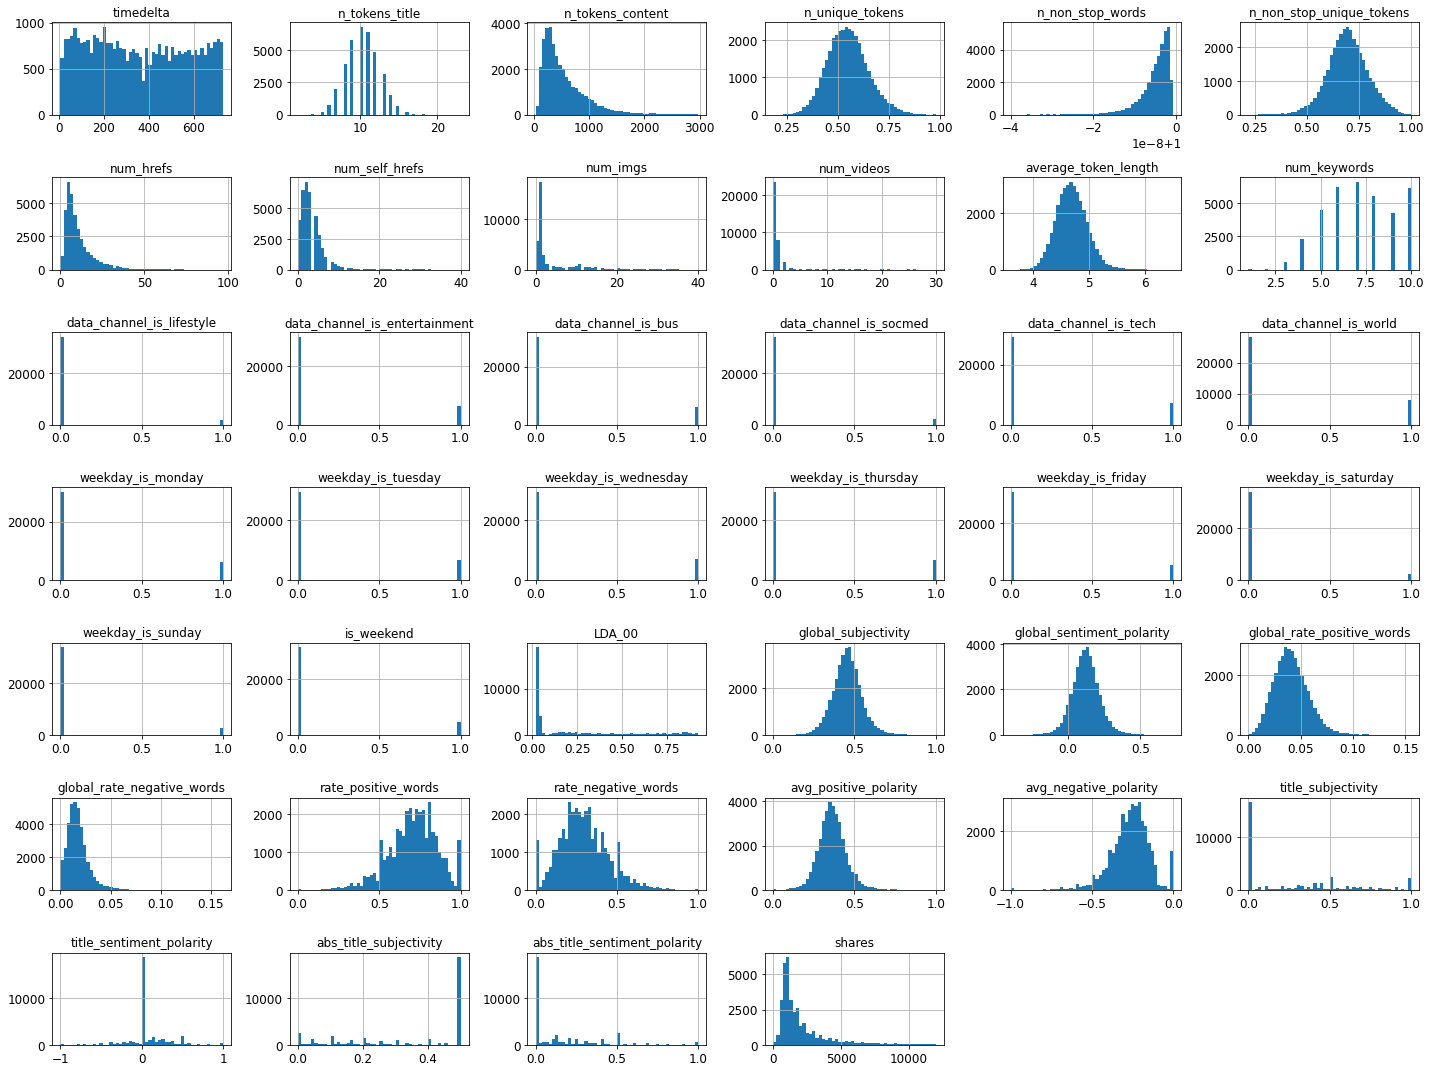

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
news.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Looking for Correlations

In [89]:
corr_matrix = news.corr()

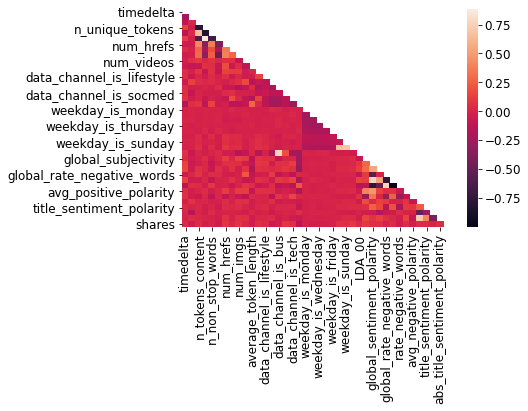

In [90]:
import seaborn as sns
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask)
plt.savefig("Correlation_Heat_Map")

In [91]:
# Show high correlation pairs
def high_corr(corr_matrix, abs_threshold):
    high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
    high_corr = pd.DataFrame(high_corr[high_corr>=abs_threshold]).reset_index()
    high_corr = high_corr[high_corr.level_0 != high_corr.level_1]
    high_corr = high_corr[high_corr.index%2==0]
    return(high_corr)

corrs = high_corr(corr_matrix, 0.7)
corrs

,level_0,level_1,0
40,rate_negative_words,rate_positive_words,0.997527
42,n_non_stop_unique_tokens,n_unique_tokens,0.882169
44,n_non_stop_words,n_unique_tokens,0.818427
46,n_tokens_content,n_unique_tokens,0.785257
48,data_channel_is_bus,LDA_00,0.777445
50,global_sentiment_polarity,rate_positive_words,0.776888
52,rate_negative_words,global_sentiment_polarity,0.776713
54,rate_negative_words,global_rate_negative_words,0.758476
56,rate_positive_words,global_rate_negative_words,0.756498
58,title_subjectivity,abs_title_sentiment_polarity,0.715640


In [92]:
# Remove level_1 feature of of high-correlation pairs
news = news.drop(set(corrs.level_1), axis=1)
corr_matrix = news.corr()
high_corr(corr_matrix, 7)

,level_0,level_1,0


In [93]:
corr_matrix["shares"].sort_values(ascending=False)

shares                           1.000000
global_subjectivity              0.098821
is_weekend                       0.096907
num_hrefs                        0.089031
data_channel_is_socmed           0.084995
num_imgs                         0.077988
weekday_is_saturday              0.070032
global_rate_positive_words       0.061316
data_channel_is_tech             0.060558
num_keywords                     0.057497
avg_positive_polarity            0.048895
title_subjectivity               0.039443
title_sentiment_polarity         0.038207
timedelta                        0.032331
n_tokens_content                 0.031169
data_channel_is_lifestyle        0.030915
num_self_hrefs                   0.026384
num_videos                       0.023549
n_non_stop_words                 0.007356
abs_title_subjectivity           0.004289
weekday_is_friday               -0.002989
weekday_is_monday               -0.010223
weekday_is_tuesday              -0.022027
weekday_is_thursday             -0

# Discover and Visualize the Data to Gain Insights

Saving figure scatter_matrix_plot


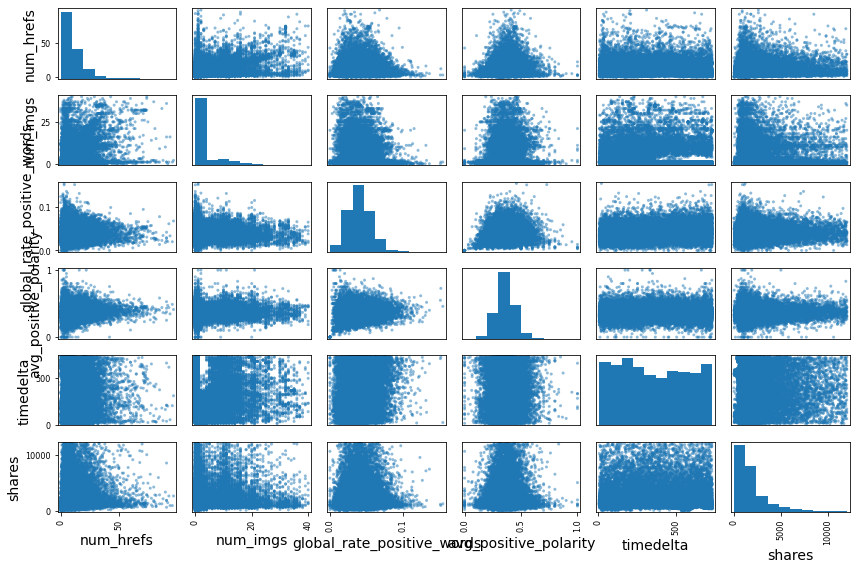

In [151]:
# Visualize scatter plot distributions of highest correlation numerical values with shates

from pandas.plotting import scatter_matrix

attributes = ["num_hrefs", "num_imgs", "global_rate_positive_words", "avg_positive_polarity", "timedelta", "shares"]
scatter_matrix(news[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

## Create a Test Set

In [95]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(news, test_size=0.2, random_state=42)

In [96]:
test_set.head()

,timedelta,n_tokens_title,n_tokens_content,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,is_weekend,global_subjectivity,global_rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,shares
15196,438.0,10.0,291.0,1.0,0.769697,3.0,2.0,1.0,0.0,4.553265,...,1.0,0.414690,0.034364,0.285714,0.326970,-0.081250,0.333333,0.25,0.166667,1300
28809,179.0,8.0,489.0,1.0,0.463068,9.0,4.0,19.0,2.0,5.079755,...,1.0,0.536927,0.040900,0.166667,0.351136,-0.236806,0.700000,0.80,0.200000,906
39450,13.0,7.0,524.0,1.0,0.743440,3.0,3.0,21.0,0.0,4.484733,...,0.0,0.394230,0.028626,0.423077,0.427027,-0.301263,0.000000,0.00,0.500000,4000
37900,37.0,14.0,286.0,1.0,0.715976,3.0,1.0,1.0,0.0,4.482517,...,0.0,0.439583,0.027972,0.428571,0.393750,-0.175694,0.000000,0.00,0.500000,6500
26882,210.0,10.0,534.0,1.0,0.793210,13.0,0.0,2.0,1.0,5.136704,...,0.0,0.514590,0.041199,0.371429,0.380170,-0.401923,0.000000,0.00,0.500000,1200


In [97]:
news = train_set

# Prepare the Data for Machine Learning Algorithms

In [123]:
x = train_set.drop("shares", axis=1) # drop labels for training set
y = train_set["shares"].copy()

32

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

In [120]:
from sklearn.compose import ColumnTransformer

cat_attribs = ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday",
              "weekday_is_friday", "weekday_is_saturday", "is_weekend", 
              "data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus",
              "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]
num_attribs = x.copy().drop(cat_attribs, axis=1).columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ], remainder="passthrough")

news_prepared = full_pipeline.fit_transform(x)

In [121]:
news_prepared

array([[-0.37757268, -0.65607489, -1.10034842, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80189948, -0.1815225 , -0.08058278, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.15131761, -1.60517968,  1.36428999, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.67084701, -0.1815225 , -0.69981396, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.66778181, -1.13062728,  0.45510134, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20280251, -0.1815225 , -0.75141656, ...,  0.        ,
         0.        ,  1.        ]])

In [122]:
news_prepared.shape

(29016, 32)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [124]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(news_prepared, y)

LinearRegression()

In [125]:
from sklearn.metrics import mean_squared_error

# In-sample RMSE
news_predictions = lin_reg.predict(news_prepared)
lin_mse = mean_squared_error(y, news_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1947.7798504917728

In [126]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y, news_predictions)
lin_mae

1313.865235588267

In [127]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(news_prepared, y)

DecisionTreeRegressor(random_state=42)

In [128]:
# In-sample RMSE
news_predictions = tree_reg.predict(news_prepared)
tree_mse = mean_squared_error(y, news_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

### Decision Tree

In [129]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, news_prepared, y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [130]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [2819.86866247 2876.42877307 2853.60747076 2771.23250147 2786.58676325
 2843.68373785 2787.17783614 2845.81026326 2851.32909646 2752.70883095]
Mean: 2818.8433935671032
Standard deviation: 39.508251007176284


### Linear Regression

In [131]:
lin_scores = cross_val_score(lin_reg, news_prepared, y,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1940.04332032 1996.61348701 2026.36746322 1929.49775325 1973.69763228
 1959.53299933 1859.53801501 2019.62185318 1932.22180286 1859.73353259]
Mean: 1949.686785906299
Standard deviation: 55.380891672444214


### Random Forest

In [132]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(news_prepared, y)

RandomForestRegressor(random_state=42)

In [133]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, news_prepared, y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1941.30667715 2004.65816746 2005.4716647  1951.08156531 1975.38853629
 1979.33772932 1892.05005461 2023.85813142 1940.88530719 1895.21709029]
Mean: 1960.92549237493
Standard deviation: 42.83741982076892


### Gradient Boosting Trees

In [136]:
from sklearn.ensemble import GradientBoostingRegressor

gbt_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)

gbt_scores = cross_val_score(gbt_reg, news_prepared, y,
                                       scoring="neg_mean_squared_error", cv=10)
gbt_rmse_scores = np.sqrt(-gbt_scores)
display_scores(gbt_rmse_scores)

Scores: [1917.44307835 1976.72484694 2008.1253456  1918.91623235 1955.20605179
 1939.87783478 1847.10090335 1999.34418936 1912.09528064 1847.04488717]
Mean: 1932.187865034338
Standard deviation: 53.04277783924023


### Support Vector Machines

In [137]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")

svm_scores = cross_val_score(svm_reg, news_prepared, y,
                            scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [2067.75747262 2135.00925714 2191.08315843 2073.0312479  2106.84852105
 2102.35527609 2009.48131126 2169.43584221 2069.1275488  1975.24961482]
Mean: 2089.9379250315915
Standard deviation: 63.134314026885406


### K Nearest Neighbors

In [138]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(weights="distance")

knn_scores = cross_val_score(knn_reg, news_prepared, y,
                            scoring="neg_mean_squared_error", cv=10)

knn_rmse_scores = np.sqrt(-knn_scores)

display_scores(knn_rmse_scores)

Scores: [2083.56020828 2139.75632144 2139.74862587 2088.94282708 2117.67694246
 2081.8000633  2035.26638163 2139.63473516 2054.64601031 2047.98068727]
Mean: 2092.9012802787906
Standard deviation: 37.70568499129963


### Stacked Model

Linear Regression and GBT prformed best in the CV tests, next we test there stacked performance.

In [139]:
from sklearn.ensemble import StackingRegressor

est = [("GBT", GradientBoostingRegressor(n_estimators=100 ,random_state=42))]

stk_reg = StackingRegressor(estimators=est, final_estimator=LinearRegression())

stk_scores = cross_val_score(stk_reg, news_prepared, y,
                            scoring="neg_mean_squared_error", cv=10)

stk_rmse_scores = np.sqrt(-stk_scores)

display_scores(stk_rmse_scores)

Scores: [1916.78877297 1977.45288214 2006.10331768 1917.80009908 1956.06451524
 1940.19263422 1845.99936039 1998.12646702 1910.24372673 1846.04957996]
Mean: 1931.4821355429954
Standard deviation: 53.16338297941016


No significant improvement over running the GBT alone. The following section looks to fine tune the GBT model to minimize corss vlidation RMSE.

# Fine-Tune Your Model

## Grid Search

In [140]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150], 
    'subsample': [0.80, 1],
    'max_depth': [3,5]}

forest_reg = GradientBoostingRegressor(random_state=42)
# train across 5 folds, that's a total of (12*5)*5=60 rounds of training 
grid_search = GridSearchCV(gbt_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(news_prepared, y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [3, 5], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1]},
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [141]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}

In [142]:
grid_search.best_estimator_

GradientBoostingRegressor(n_estimators=150, random_state=42, subsample=0.8)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [143]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1938.4400534884423 {'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
1938.5756351645903 {'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
1933.24218330308 {'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
1934.6638909227333 {'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
1931.2390476718474 {'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
1932.9331381869354 {'max_depth': 3, 'n_estimators': 150, 'subsample': 1}
1935.2297455722648 {'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
1935.1045170758057 {'max_depth': 5, 'n_estimators': 50, 'subsample': 1}
1936.1867447395528 {'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
1934.8735843367406 {'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
1940.0561894044122 {'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
1936.9425907494124 {'max_depth': 5, 'n_estimators': 150, 'subsample': 1}


The improved performance gained by increasing estimators is not worth the runtime cost. Below we look at the results for 100 estimators

In [144]:
results = pd.DataFrame(grid_search.cv_results_)
results[results.param_n_estimators==100]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,5.930120,0.030515,0.009370,0.007650,3,100,0.8,"{'max_depth': 3, 'n_estimators': 100, 'subsamp...",-3.779849e+06,-3.876402e+06,...,-3.737425e+06,118552.137941,3,-3.542485e+06,-3.535992e+06,-3.531027e+06,-3.572683e+06,-3.601953e+06,-3.556828e+06,26807.290506
3,7.927859,0.726889,0.006249,0.007653,3,100,1,"{'max_depth': 3, 'n_estimators': 100, 'subsamp...",-3.801593e+06,-3.869678e+06,...,-3.742924e+06,114628.473948,4,-3.552019e+06,-3.541776e+06,-3.554046e+06,-3.582583e+06,-3.606949e+06,-3.567475e+06,23942.086115
8,10.442674,0.639451,0.015184,0.001338,5,100,0.8,"{'max_depth': 5, 'n_estimators': 100, 'subsamp...",-3.791852e+06,-3.878653e+06,...,-3.748819e+06,120083.763657,8,-3.101355e+06,-3.059255e+06,-3.085238e+06,-3.073907e+06,-3.129752e+06,-3.089901e+06,24232.226925
9,21.463137,12.686572,0.025189,0.025916,5,100,1,"{'max_depth': 5, 'n_estimators': 100, 'subsamp...",-3.798938e+06,-3.857995e+06,...,-3.743736e+06,110387.573824,5,-3.125740e+06,-3.098818e+06,-3.107550e+06,-3.125729e+06,-3.161615e+06,-3.123890e+06,21566.519681


Increasing depth also significantly increses runtime with no positive effect on predictive performance. Reducing the subsmple portion appears to reduce runtime while improving predictive performace, within the tested range.

## Randomized Search

In [145]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distribs = {
        'subsample': uniform(loc = 0.5, scale = 0.5),
        'max_features': uniform(loc = 0.3, scale = 0.7)
}

gbt_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)
rnd_search = RandomizedSearchCV(gbt_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(news_prepared, y)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B2A6479340>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B2A63882B0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [146]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1932.476519925346 {'max_features': 0.5621780831931538, 'subsample': 0.9753571532049581}
1932.082441602814 {'max_features': 0.8123957592679836, 'subsample': 0.7993292420985183}
1933.8334486939561 {'max_features': 0.40921304830970556, 'subsample': 0.5779972601681014}
1934.006494356744 {'max_features': 0.3406585285177396, 'subsample': 0.9330880728874675}
1932.8062616815 {'max_features': 0.7207805082202461, 'subsample': 0.8540362888980227}
1934.0528616322933 {'max_features': 0.3144091460070617, 'subsample': 0.9849549260809971}
1933.9805622437345 {'max_features': 0.8827098485602951, 'subsample': 0.6061695553391381}
1933.9708875443462 {'max_features': 0.42727747704497043, 'subsample': 0.5917022549267169}
1933.6151251528097 {'max_features': 0.5129695700716763, 'subsample': 0.762378215816119}
1934.8398639915497 {'max_features': 0.602361513049481, 'subsample': 0.645614570099021}


Varying the max_feature and subsample proportions does not yield significant improvements either

In [147]:
rnd_search.best_params_

{'max_features': 0.8123957592679836, 'subsample': 0.7993292420985183}

## Analyze the Best Models and Their Errors

In [170]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.90537823e-02, 1.99903524e-02, 4.35561832e-02, 3.81537744e-02,
       3.63526313e-02, 7.22319411e-02, 2.69662094e-02, 7.06471772e-02,
       2.69397836e-02, 4.37472703e-02, 1.65624857e-02, 4.65075895e-02,
       2.12491654e-02, 1.78329542e-02, 2.50828826e-02, 1.47187341e-02,
       1.45862750e-02, 1.41342656e-02, 6.00302335e-03, 1.43251341e-03,
       8.40235424e-02, 2.19764139e-02, 5.72918494e-02, 1.24202463e-02,
       1.09243526e-01, 1.21705715e-05, 6.93735546e-04, 3.81926916e-03,
       0.00000000e+00, 8.55993575e-04, 5.89416711e-03, 6.80200923e-02])

In [171]:
sorted(zip(feature_importances, news.columns[:-1]), reverse=True)

[(0.10924352565256565, 'global_subjectivity'),
 (0.08402354239453073, 'weekday_is_thursday'),
 (0.07905378228219696, 'timedelta'),
 (0.07223194112863159, 'num_hrefs'),
 (0.07064717724407739, 'num_imgs'),
 (0.06802009232598834, 'abs_title_subjectivity'),
 (0.05729184940158912, 'weekday_is_saturday'),
 (0.04650758946431062, 'data_channel_is_lifestyle'),
 (0.04374727028498274, 'average_token_length'),
 (0.043556183177562574, 'n_tokens_content'),
 (0.03815377438316352, 'n_non_stop_words'),
 (0.03635263133690199, 'n_non_stop_unique_tokens'),
 (0.026966209370881185, 'num_self_hrefs'),
 (0.026939783627736334, 'num_videos'),
 (0.025082882567778658, 'data_channel_is_socmed'),
 (0.021976413921653015, 'weekday_is_friday'),
 (0.02124916536671222, 'data_channel_is_entertainment'),
 (0.01999035242574082, 'n_tokens_title'),
 (0.017832954226994525, 'data_channel_is_bus'),
 (0.01656248570970193, 'num_keywords'),
 (0.014718734070546085, 'data_channel_is_tech'),
 (0.01458627499095197, 'data_channel_is_wo

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_non_stop_words',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'is_weekend', 'global_subjectivity',
       'global_rate_positive_words', 'rate_negative_words',
       'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity', 'shares'],
      dtype='object')

Based on the feature importance scores, it appears that the global subjectivity score of the article is the single most powerful feature in determining the number of shares. In fact, 3 of the 5 most powerful features (global subjectivity, number of links, number of images) are related to the article contents, supporting the hypothesis that article content significantly impacts the number of shares.

The high ranking of time related features such as days passed since publication and whether the article was released on a Thursday indicates that time of release and time since release impact the number of shares significantly. The importance of time since release suggests that there is an underlying timeseries trend, such as changes in Mashable's popularity over time, or a steady increase in number of shares since article publication.

Based on the impact of these features, it may be benficial to correct the target based on the popularity of the site and days since publication, e.g. shares per reader in the month after publication. These corrections would allow for a more precise examination of the importance of content-related features. Unfortunatly, the required data points to perform this correction are not provided in the data source.

Equally interesting is the lower end of the spectrum where features such as the rate of positive/negative words in the article, the subjectivity and sentiment score of the title showed no significant predictive power. This challenges the widely held belief that articles with "click-bait" titles or negative content are more likely to be shared to the masses. These scores imply that such tactics have a negigibl effect on he number of shares for most titles.

### Further Feature Selection

Based on the large varience in feaure importance, we attempt to reduce the number of features to improve the generlizability of the model.

In [153]:
model = rnd_search.best_estimator_

from sklearn.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(model, n_features_to_select=0.5, direction="backward", scoring='neg_mean_squared_error', cv = 5, n_jobs=-1)

selector.fit(news_prepared, y)

SequentialFeatureSelector(direction='backward',
                          estimator=GradientBoostingRegressor(max_features=0.8123957592679836,
                                                              random_state=42,
                                                              subsample=0.7993292420985183),
                          n_features_to_select=0.5, n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [158]:
red_news_prep = selector.transform(news_prepared)

model = GradientBoostingRegressor(n_estimators=100, max_features = 0.8123957592679836, subsample = 0.7993292420985183)

red_scores = cross_val_score(model, red_news_prep, y,
                                scoring="neg_mean_squared_error", cv=10)

red_rmse_scores = np.sqrt(-red_scores)
display_scores(red_rmse_scores)

Scores: [1913.69867237 1969.00816953 2008.57860247 1918.57250334 1952.25339299
 1943.50771287 1845.89988571 1997.05761768 1913.9862957  1849.01718081]
Mean: 1931.158003346242
Standard deviation: 52.097049964939984


In [173]:
model.fit(red_news_prep, y)
feature_importances = model.feature_importances_
feature_importances

array([0.10956857, 0.09576854, 0.09612587, 0.04409062, 0.08739297,
       0.04047703, 0.07222492, 0.02918896, 0.10227078, 0.04454711,
       0.05285846, 0.00956854, 0.13208012, 0.00038849, 0.0030849 ,
       0.08036412])

In [174]:
sorted(zip(feature_importances, news.columns[:-1][selector.get_support()]), reverse=True)

[(0.13208011954743418, 'global_subjectivity'),
 (0.10956857154283982, 'timedelta'),
 (0.10227078087346994, 'weekday_is_thursday'),
 (0.09612587246602933, 'num_hrefs'),
 (0.09576854103492005, 'n_non_stop_words'),
 (0.08739296900787133, 'num_imgs'),
 (0.08036412057620805, 'abs_title_subjectivity'),
 (0.07222492121873558, 'average_token_length'),
 (0.052858459217886164, 'weekday_is_saturday'),
 (0.044547107150250655, 'weekday_is_friday'),
 (0.04409062165972659, 'num_self_hrefs'),
 (0.0404770261890364, 'num_videos'),
 (0.029188964360641143, 'num_keywords'),
 (0.009568536913961218, 'is_weekend'),
 (0.0030849006738505585, 'avg_positive_polarity'),
 (0.0003884875671389935, 'global_rate_positive_words')]

## Evaluate System on the Test Set

In [178]:
final_model = model

X_test = test_set.drop("shares", axis=1)
y_test = test_set["shares"].copy()

X_test_prepared = full_pipeline.transform(X_test)
red_X_test_prep = selector.transform(X_test_prepared)
final_predictions = final_model.predict(red_X_test_prep)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [179]:
final_rmse

1932.739155987818

We can compute a 95% confidence interval for the test RMSE:

In [180]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([1866.61907846, 1996.67085573])

# Conclusion

Based on the above analysis, we were not able to achieve the required predictive performance within a 95% confidence interval, acheiving a mean RMSE (1932) that is larger than the target median (1400). To better assess the role played by article content in increasing the number of shares, the analysis suggests a more appropriate target is required to correct for variance based on time-based trends, such as the shares per reader within the first month of publication.

The article's global subjectivity consistently scored the highest in terms of feature importance in the best performing models. Most sentiment-related features ranked low in terms of predictive power, and were thus removed during feature selection. At the current performance level of the model, however, we are not confident in making any inferences based on these results.

Given the low performance of the predictive model it is unlikely that further analysis and finetuning of the model will achieve the desired outcome. If further analysis is to be undertaken, our reccomendation is to widen the data acquisition scope, to capture number of shares in first month of publication, number of readers, number of readers from shared links, and higher categorical granularity when indicating the subject of the article.